## Importando Bibliotecas

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
import random

#modelo e métricas
from sklearn.model_selection import train_test_split,learning_curve,KFold, StratifiedKFold, LeaveOneOut, cross_validate, validation_curve,  ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report


#árvore de classificação
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

#visualização
from yellowbrick.model_selection import LearningCurve

##  Prevendo o salário com dados do censo


Vamos usar um dataset do censo dos Estados Unidos disponível no UCI Machine Learning Repository para tentar classificar se uma pessoa recebe mais de $ 50.000,00 por ano. O arquivo census.csv contem o censo de 1994 com um total de 31.978 indivíduos e possui as seguintes variáveis:

* age: a idade em anos
* workclass: classificação do tipo de trabalho da pessoa (exemplo: trabalha pro governo federal, não trabalha pro governo federal, trabalha sem remuneração, etc).
* education: o nível de educação (exemplos: high school, 5th-6th grade, PhD, etc)
* maritalstatus: o estado civil da pessoa.
* occupation: o tipo de trabalho (ex.: administrativo, vendas, etc)
* relationship: relacionamento do indivíduo com os membros da sua família
* race: raça da pessoa
* sex: sexo da pessoa
* capitalgain: o ganho de capital de pessoa em 1994 (por vender alguma propriedade)
* capitalloss: o prejuízo de capital de uma pessoa 
* hoursperweek: número de horas trabalhadas por semana
* nativecountry: o país de nascimento
* over50k: se o indivíduo ganhou mais de $50.000,00 em 1994



### Análise exploratória

In [2]:
salario = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/census.csv', sep = ',')
salario.head()

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
salario.isnull().sum()

age              0
workclass        0
education        0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
nativecountry    0
over50k          0
dtype: int64

In [4]:
salario.duplicated().sum()

3462

In [5]:
salario.drop_duplicates(inplace= True)

In [6]:
salario.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28516 entries, 0 to 31977
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            28516 non-null  int64 
 1   workclass      28516 non-null  object
 2   education      28516 non-null  object
 3   maritalstatus  28516 non-null  object
 4   occupation     28516 non-null  object
 5   relationship   28516 non-null  object
 6   race           28516 non-null  object
 7   sex            28516 non-null  object
 8   capitalgain    28516 non-null  int64 
 9   capitalloss    28516 non-null  int64 
 10  hoursperweek   28516 non-null  int64 
 11  nativecountry  28516 non-null  object
 12  over50k        28516 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.0+ MB


In [7]:
#Unique
for column in salario:
  if column != 'capitalgain' and column != 'capitalloss' :
    print(column,':' , salario[column].unique())

age : [39 50 38 53 28 37 49 52 31 42 30 23 32 34 25 43 40 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 47 46 36 79 27 67 18 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass : [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education : [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
maritalstatus : [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation : [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relationship : [' Not-i

In [8]:
salario['over50k'] = salario['over50k'].map({' <=50K':0, ' >50K' :1})
salario.head(5)

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [9]:
# Percentual dos que recebem > 50k
len(salario.loc[salario['over50k'] == 1])/len(salario['over50k'])
# 24% tem salario > 50k, dataset desbalanceado

0.2477556459531491

In [10]:
salario.describe()

,age,capitalgain,capitalloss,hoursperweek,over50k
count,28516.000000,28516.000000,28516.000000,28516.000000,28516.000000
mean,39.261046,1185.231204,96.733764,40.619512,0.247756
std,13.711978,7693.642033,422.964800,12.740703,0.431717
min,17.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,0.000000,0.000000,39.000000,0.000000
50%,38.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,4356.000000,99.000000,1.000000


### Divisão do dataset em treino e teste. 

In [11]:
salario.head(4)

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0


In [12]:
X_sal, y_sal = salario.drop('over50k', axis=1), salario['over50k'] 
X_sal_train, X_sal_test, y_sal_train, y_sal_test = train_test_split(X_sal, y_sal, stratify=y_sal, test_size=0.25, random_state=123)

In [13]:
y_sal_train.value_counts()

0    16088
1     5299
Name: over50k, dtype: int64

### Árvore de classificação com validação cruzada para escolher o melhor parâmetro de ccp_alpha e max_depth

In [14]:
cv_skfold_sal= StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [41]:
# Selecionando as features para o one hot encoder
cat_columns_sal = X_sal.select_dtypes(include=['object']).columns.tolist()
cat_columns_sal

['workclass',
 'education',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'nativecountry']

In [16]:
pipe_cat_columns_sal = ('one_hot_encoder', 
                          OneHotEncoder(handle_unknown='ignore'),
                        cat_columns_sal)

tranformers_sal =[ pipe_cat_columns_sal]

In [42]:
pre_processor = ColumnTransformer(tranformers_sal)
pre_processor

ColumnTransformer(transformers=[('one_hot_encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['workclass', 'education', 'maritalstatus',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'nativecountry'])])

In [43]:
#pipeline
pipe_tree_sal = Pipeline(steps=[('pre_processor',pre_processor),
                               ('model', DecisionTreeClassifier(class_weight= 'balanced'))])

In [44]:
#fit da árvore de classificação
pipe_tree_sal.fit(X_sal_train, y_sal_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'maritalstatus',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'nativecountry'])])),
                ('model', DecisionTreeClassifier(class_weight='balanced'))])

In [45]:
#Performance com acurária
print(f'accuracy salario treino: {accuracy_score(y_sal_train, pipe_tree_sal.predict(X_sal_train))}')
print(f'accuracy salario teste: {accuracy_score(y_sal_test, pipe_tree_sal.predict(X_sal_test))}')

accuracy salario treino: 0.8294290924393323
accuracy salario teste: 0.7598541169869547


In [46]:
#Performance com log loss
print(f'log loss salario treino: {log_loss(y_sal_train, pipe_tree_sal.predict(X_sal_train))}')
print(f'log loss teste: {log_loss(y_sal_test, pipe_tree_sal.predict(X_sal_test))}')

log loss salario treino: 5.891430934266222
log loss teste: 8.294494354308334


### Busca dos melhores hiperparâmetros

In [47]:
# Definição da grid para o random search
param_random_sal = dict()
param_random_sal['model__ccp_alpha'] = (np.arange(0.0,0.002, 0.0001)).tolist()
param_random_sal['model__max_depth'] = (np.arange(5,25,1)).tolist()
# param_random_sal

In [48]:
#Random search com acurácia
random_search_sal = RandomizedSearchCV(pipe_tree_sal, param_random_sal, cv= cv_skfold_sal , scoring='accuracy', return_train_score=True, n_iter = 50, random_state = 123)

In [49]:
random_search_sal.fit(X_sal_train, y_sal_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('one_hot_encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['workclass',
                                                                                'education',
                                                                                'maritalstatus',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                           

In [51]:
random_search_sal.best_score_

0.7747697555006557

In [52]:
random_search_sal.best_params_

{'model__max_depth': 24, 'model__ccp_alpha': 0.00030000000000000003}

In [27]:
# Modelo com os hiperparâmetros tunados
tree_sal_random_search = random_search_sal.best_estimator_
tree_sal_random_search 

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'maritalstatus',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'nativecountry'])],
                                   verbose=True)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.00030000000000000003,
                                        class_weight='balanced',
                                        max_depth=24))])

### Comparação da árvore com melhores hiperparâmetros com uma árvore sem otimização

In [28]:
#Performance sem otimizar hiperparâmetros
print(f'accuracy salario treino: {accuracy_score(y_sal_train, pipe_tree_sal.predict(X_sal_train))}')
print(f'accuracy salario teste: {accuracy_score(y_sal_test, pipe_tree_sal.predict(X_sal_test))}')

accuracy salario treino: 0.8294290924393323
accuracy salario teste: 0.7591527563473138


In [29]:
#Performance otimizando hiperparâmetros
print(f'accuracy salario treino: {accuracy_score(y_sal_train, tree_sal_random_search.predict(X_sal_train))}')
print(f'accuracy salario teste: {accuracy_score(y_sal_test, tree_sal_random_search.predict(X_sal_test))}')

accuracy salario treino: 0.7784635526254267
accuracy salario teste: 0.7656052742320101


In [30]:
#Performance sem otimizar hiperparâmetros - log loss score
print(f'log_loss salario treino: {log_loss(y_sal_train, pipe_tree_sal.predict(X_sal_train))}')
print(f'log_loss salario teste: {log_loss(y_sal_test, pipe_tree_sal.predict(X_sal_test))}')

log_loss salario treino: 5.891430934266222
log_loss salario teste: 8.318718716935548


In [31]:
#Performance otimizando hiperparâmetros -  log loss
print(f'log loss salario treino: {log_loss(y_sal_train, tree_sal_random_search.predict(X_sal_train))}')
print(f'log loss salario teste: {log_loss(y_sal_test, tree_sal_random_search.predict(X_sal_test))}')

log loss salario treino: 7.651743853118678
log loss salario teste: 8.095859560723918


### Plot_tree para visualizar as árvores

In [32]:
#resgatando os nomes das features do one hot encoder com pipeline
feature_names_sal = tree_sal_random_search.named_steps['pre_processor'].transformers_[0][1].get_feature_names()

[Text(463.1067558890633, 646.696551724138, 'x2_ Married-civ-spouse <= 0.5\ngini = 0.5\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass =  >50K'),
 Text(301.02066648265935, 635.4496551724138, 'x3_ Exec-managerial <= 0.5\ngini = 0.306\nsamples = 54.5%\nvalue = [0.812, 0.188]\nclass =  <=50K'),
 Text(235.02063515786747, 624.2027586206897, 'x3_ Prof-specialty <= 0.5\ngini = 0.261\nsamples = 49.3%\nvalue = [0.846, 0.154]\nclass =  <=50K'),
 Text(180.30266100417123, 612.9558620689655, 'x1_ Bachelors <= 0.5\ngini = 0.187\nsamples = 42.9%\nvalue = [0.895, 0.105]\nclass =  <=50K'),
 Text(154.6307960449842, 601.7089655172414, 'x1_ Masters <= 0.5\ngini = 0.153\nsamples = 39.0%\nvalue = [0.916, 0.084]\nclass =  <=50K'),
 Text(136.52268352612825, 590.4620689655173, 'x4_ Own-child <= 0.5\ngini = 0.143\nsamples = 38.5%\nvalue = [0.923, 0.077]\nclass =  <=50K'),
 Text(109.9722728176468, 579.2151724137932, 'x6_ Female <= 0.5\ngini = 0.183\nsamples = 27.2%\nvalue = [0.898, 0.102]\nclass =  <=50K'),
 Text(70

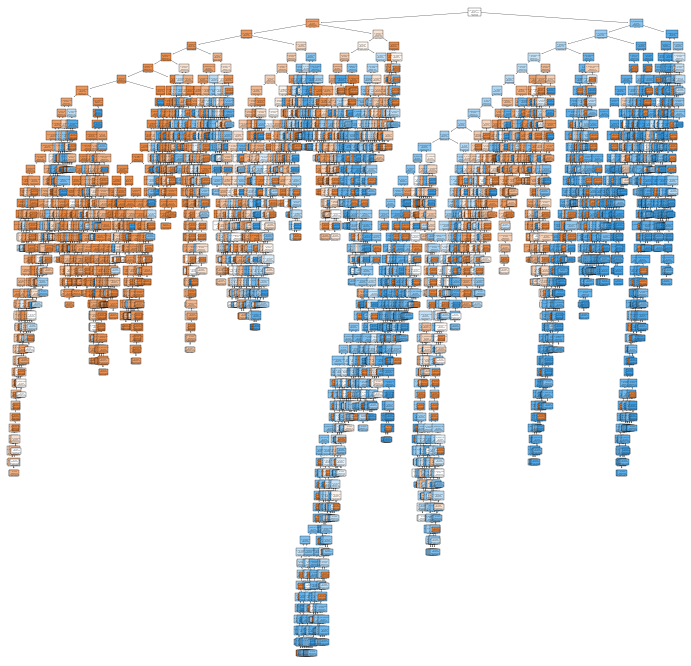

In [33]:
#árvore sem otimizar hiperparâmetros
plt.figure(figsize=(12,12)) 
#plot da árvore usando pipeline
plot_tree(pipe_tree_sal['model'], class_names= [' <=50K', ' >50K'], feature_names= feature_names_sal, filled = True, impurity= True, proportion = True)

[Text(600.7120786516854, 791.4176470588235, 'x2_ Married-civ-spouse <= 0.5\ngini = 0.5\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass =  >50K'),
 Text(449.064606741573, 743.4529411764706, 'x3_ Exec-managerial <= 0.5\ngini = 0.306\nsamples = 54.5%\nvalue = [0.812, 0.188]\nclass =  <=50K'),
 Text(343.26404494382024, 695.4882352941177, 'x3_ Prof-specialty <= 0.5\ngini = 0.261\nsamples = 49.3%\nvalue = [0.846, 0.154]\nclass =  <=50K'),
 Text(244.51685393258427, 647.5235294117647, 'x1_ Bachelors <= 0.5\ngini = 0.187\nsamples = 42.9%\nvalue = [0.895, 0.105]\nclass =  <=50K'),
 Text(197.4943820224719, 599.5588235294117, 'x1_ Masters <= 0.5\ngini = 0.153\nsamples = 39.0%\nvalue = [0.916, 0.084]\nclass =  <=50K'),
 Text(178.68539325842696, 551.5941176470587, 'x4_ Own-child <= 0.5\ngini = 0.143\nsamples = 38.5%\nvalue = [0.923, 0.077]\nclass =  <=50K'),
 Text(159.87640449438203, 503.6294117647059, 'x6_ Female <= 0.5\ngini = 0.183\nsamples = 27.2%\nvalue = [0.898, 0.102]\nclass =  <=50K'),
 Text(94

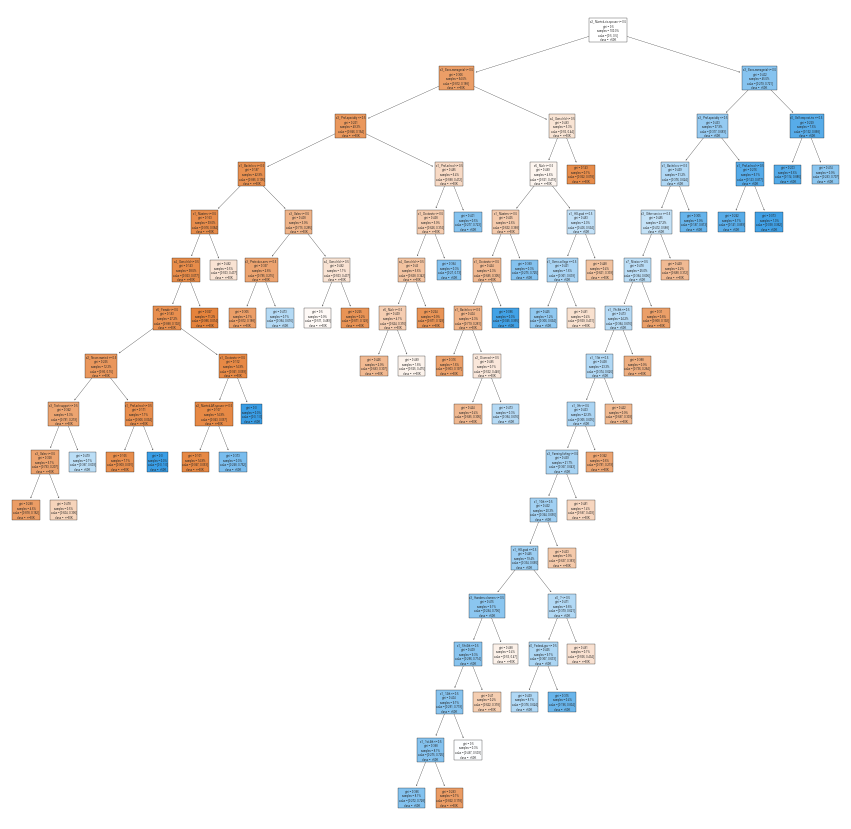

In [34]:
#árvore com hiperparâmetros otimizados
# altos valores de gini indicam altos valores de  heterogeneidade

plt.figure(figsize=(15,15)),

#plot da árvore usando pipeline
plot_tree(tree_sal_random_search['model'], class_names= [' <=50K', ' >50K'], feature_names = feature_names_sal, filled= True, impurity= True,  proportion = True)

Sem a otimização a árvore apresenta overfitting, já com os hiperparâmetros otimizados a árvore é podada e não apresenta overfitting

Além disso, a acurácia para o conjunto de treino reduz com a otimização, e para o conjunto de teste a acurácia aumenta com a otimização. Isto é interessante porque uma acurácia maior para o conjunto de teste mostra que o modelo consegue generalizar melhor para dados novos.

### Validation curves das duas árvores

In [35]:
param_range_sal_val = np.arange(0,0.001, 0.0001).tolist()

[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=

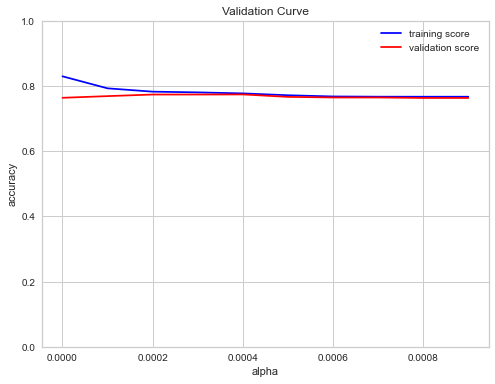

In [36]:
# Validation curve para alpha, usando yellow brick, e accuracy
plt.figure(figsize=(8,6))

# obendo os scores de validação para treino e teste
# utilizando a classe validation curve
degree = np.arange(0, 21)
train_score_sal, val_score_sal = validation_curve(estimator=pipe_tree_sal, 
                                          X=X_sal_train, 
                                          y=y_sal_train, 
                                          param_name='model__ccp_alpha', 
                                          param_range= param_range_sal_val, 
                                          cv= cv_skfold_sal, scoring = 'accuracy') # Cross-Validation hyper-param

# plotando as curvas de teste e validação
plt.plot( param_range_sal_val, np.median(train_score_sal, 1), color='blue', label='training score')
plt.plot( param_range_sal_val, np.median(val_score_sal, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Validation Curve');

[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing one_hot_encoder, total=

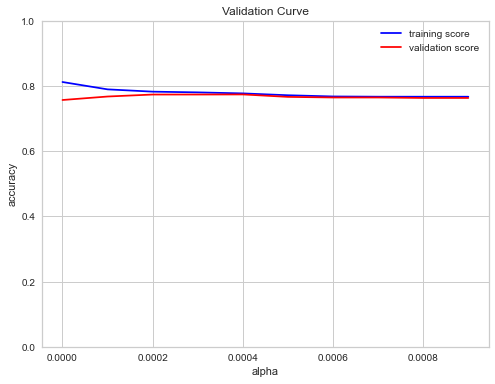

In [37]:
# Validation curve para alpha, usando yellow brick, e accuracy
plt.figure(figsize=(8,6))

# obendo os scores de validação para treino e teste
# utilizando a classe validation curve
degree = np.arange(0, 21)
train_score_sal, val_score_sal = validation_curve(estimator=tree_sal_random_search, 
                                          X=X_sal_train, 
                                          y=y_sal_train, 
                                          param_name='model__ccp_alpha', 
                                          param_range= param_range_sal_val, 
                                          cv= cv_skfold_sal, scoring = 'accuracy') # Cross-Validation hyper-param

# plotando as curvas de teste e validação
plt.plot( param_range_sal_val, np.median(train_score_sal, 1), color='blue', label='training score')
plt.plot( param_range_sal_val, np.median(val_score_sal, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Validation Curve');

### Learning curves

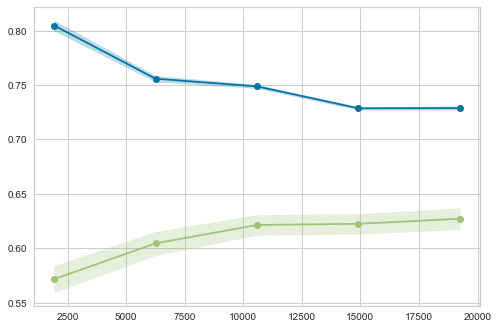

In [38]:
#learning curve sem otimização de hiperparâmetros
learning_curve_tree_sal = LearningCurve(pipe_tree_sal, cv= cv_skfold_sal,  train_sizes=np.linspace(.1, 1.0, 5), n_jobs=-1, scoring = 'f1')
learning_curve_tree_sal.fit(X_sal_train, y_sal_train);


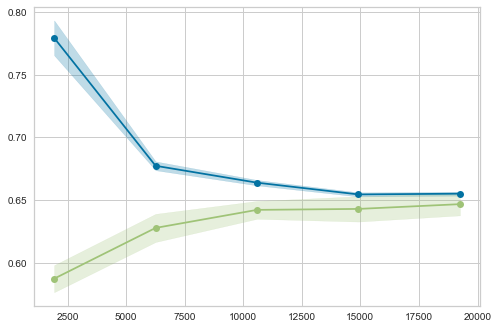

In [39]:
#learning curve com otimização de hiperparâmetros
learning_curve_tree_sal_best = LearningCurve(tree_sal_random_search, cv= cv_skfold_sal,  train_sizes=np.linspace(.1, 1.0, 5), n_jobs=-1, scoring = 'f1')
learning_curve_tree_sal_best.fit(X_sal_train, y_sal_train);

Sem a otimização de hiperparâmetros a árvore terá overfitting, que é uma característica deste tipo de modelo.

As learning curves mostram o comportamento do conjunto de treinamento e validação com o aumento do dataset.

Com a otimização há um aumento da acurácia para o conjunto de validação maior do que sem a otimização, isso é interessante porque à medida que o conjunto de validação aumenta há também aumento da acurácia maior do que sem a otimização.

Para o conjunto de treinamento ocorre o inverso: à medida que o dataset aumenta a acurácia diminui e essa queda é mais brusca para o modelo otimizado.


## Métricas e conclusões

In [53]:
#Métricas sem otimização
print(classification_report(y_sal_test, pipe_tree_sal.predict(X_sal_test)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      5363
           1       0.51      0.78      0.62      1766

    accuracy                           0.76      7129
   macro avg       0.71      0.77      0.72      7129
weighted avg       0.81      0.76      0.77      7129



In [54]:
#Métricas com otimização
print(classification_report(y_sal_test, tree_sal_random_search.predict(X_sal_test)))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      5363
           1       0.52      0.82      0.64      1766

    accuracy                           0.77      7129
   macro avg       0.72      0.79      0.73      7129
weighted avg       0.83      0.77      0.78      7129



Podemos perceber que houve melhora nas métricas com a otimização.

Entretanto, o target 1 (salário acima de 50K) não teve garnde aumento de precisão, o recall aumentou de 0.78 para 0.82


O que podemos afirmar é que o nosso modelo otimizado classifica melhor o target 0 do que o 1, ou seja prevê melhor quem tem salário abaixo de 50K.